# Prediccion de demanda

## Pendiente:
- Imputar los datos faltantes con interpolacion polinomica de cada año o con KNN
- **Mejoras en prediccion simple**: Crear pipeline (funcion) Si se quiere una validacion con solo los datos de entrenamiento

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Con reglas duras  de las variaciones por dia

**Plan:**
1. Sacar entre dias del anios consecutivos la variacion
2. Promediar (o con mediana) la variacion media al dia
3. Multiplicar los valores de los ultimos dias por la variacion calculada en el punto 2.

In [43]:
demanda_df = pd.read_csv(".\Datos\demanda.csv")

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\juanc\AppData\Local\Temp\ipykernel_27640\1703249404.py:1: SyntaxWarning: invalid escape sequence '\D'
  demanda_df = pd.read_csv(".\Datos\demanda.csv")


In [44]:
demanda_prod_df = demanda_df[demanda_df['id_producto']==1]
demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')

# Primero, asegurar que todas las fechas estan
# Los datos de demanda iniciales no tienen enero 2020
fecha_inicial = pd.to_datetime('2020-01-01')
fechas_df = pd.DataFrame({'date': pd.date_range(start=fecha_inicial, end=demanda_prod_df['date'].max())})
complete_demanda_prod_df = fechas_df.merge(demanda_prod_df
                                           ,how='left'
                                           ,left_on='date'
                                           ,right_on='date'
                                           )


complete_demanda_prod_df['anio'] = complete_demanda_prod_df['date'].dt.year
complete_demanda_prod_df['mes'] = complete_demanda_prod_df['date'].dt.month
complete_demanda_prod_df['dia'] = complete_demanda_prod_df['date'].dt.day

C:\Users\juanc\AppData\Local\Temp\ipykernel_27640\1390649101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')


In [45]:
# Preprocesamiento de la serie de tiempo
complete_demanda_prod_df['demanda'].ffill(inplace=True)
complete_demanda_prod_df['demanda'].bfill(inplace=True)

C:\Users\juanc\AppData\Local\Temp\ipykernel_27640\480715261.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_demanda_prod_df['demanda'].ffill(inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_27640\480715261.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [46]:
# Crear un dataframe vacio
complete_demanda_prod_df = complete_demanda_prod_df.sort_values(by='date', ascending=True)
complete_demanda_prod_df.reset_index(drop=True, inplace=True)

# Crear una columna indicadora para el 29 de febrero
complete_demanda_prod_df['is_feb_29'] = complete_demanda_prod_df['date'].apply(lambda x: x.month == 2 and x.day == 29)
complete_demanda_prod_df = complete_demanda_prod_df[~complete_demanda_prod_df['is_feb_29']]

# Crear la clave mes-día
complete_demanda_prod_df['mes_dia'] = complete_demanda_prod_df['mes'].astype(str) + '-' + complete_demanda_prod_df['dia'].astype(str)

# Crear la tabla pivote
transformed_df = complete_demanda_prod_df.pivot_table(index='mes_dia', columns='anio', values='demanda')

# Resetear el índice y eliminar nombres de índice no deseados
transformed_df.reset_index(inplace=True, drop=False)
transformed_df.columns.name = None  # Quita el nombre del índice de columnas

In [47]:
# Dividir la columna 'mes_dia' en dos columnas 'mes' y 'dia'
transformed_df[['mes', 'dia']] = transformed_df['mes_dia'].str.split('-', expand=True)

# Convertir las nuevas columnas a tipo entero si es necesario
transformed_df['mes'] = transformed_df['mes'].astype(int)
transformed_df['dia'] = transformed_df['dia'].astype(int)

In [50]:
# Renombrar columnas de años a 'demanda_{anio}'
transformed_df = transformed_df.rename(columns=lambda x: f"demanda_{x}" if isinstance(x, int) else x)

In [53]:
# Calculo de diferencia de datos
cols_demanda = [c for c in transformed_df.columns if 'demanda' in c]
for i,c in enumerate(cols_demanda):
    if i>0:
        transformed_df['pct_var_rel_{a}_{am1}'.format(a=cols_demanda[i][-4:], am1=cols_demanda[i-1][-4:])] = \
            (transformed_df[cols_demanda[i]] - transformed_df[cols_demanda[i-1]]) / transformed_df[cols_demanda[i-1]]

In [63]:
# Esto se hace de ultimo
# Calcular la media del porcentage de varianza relativo
N_pct_cols = float(len([c for c in transformed_df.columns if 'pct_var_rel' in c]))

# Relleno de los valores de % relativo de variacion con el promedio anual
transformed_df['pct_var_rel_2022_2021'].fillna(transformed_df['pct_var_rel_2022_2021'].mean(), inplace=True)

# Para no terminar con NaN se puede crear una funcion que calcule el promedio y luego se aplica con apply() 
transformed_df['avg_pct_var_rel'] =  (transformed_df['pct_var_rel_2021_2020'] + transformed_df['pct_var_rel_2022_2021']) / N_pct_cols



C:\Users\juanc\AppData\Local\Temp\ipykernel_27640\2171710298.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transformed_df['pct_var_rel_2022_2021'].fillna(transformed_df['pct_var_rel_2022_2021'].mean(), inplace=True)


In [66]:
# Cargue de datos para test:
demanda_test_df = pd.read_csv(".\Datos\demanda_test.csv")
demanda_test_df['date'] = pd.to_datetime(demanda_test_df['date'], format='%Y-%m-%d')
demanda_test_df = demanda_test_df[demanda_test_df['id_producto']==1]

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\juanc\AppData\Local\Temp\ipykernel_27640\3844840410.py:2: SyntaxWarning: invalid escape sequence '\D'
  demanda_test_df = pd.read_csv(".\Datos\demanda_test.csv")


In [67]:
# Primero, asegurar que todas las fechas estan
# fecha_inicial = pd.to_datetime('2020-01-01')
fechas_df = pd.DataFrame({'date': pd.date_range(start=demanda_test_df['date'].min(), end=demanda_prod_df['date'].max())})
complete_demanda_test_df = fechas_df.merge(demanda_test_df
                                           ,how='left'
                                           ,left_on='date'
                                           ,right_on='date'
                                           )

In [68]:
demanda_test_df['anio'] = demanda_test_df['date'].dt.year
demanda_test_df['mes'] = demanda_test_df['date'].dt.month
demanda_test_df['dia'] = demanda_test_df['date'].dt.day

In [69]:
# Asegurarse de que las columnas tienen el mismo nombre y tipo de datos
transformed_df['mes'] = transformed_df['mes'].astype(int)
transformed_df['dia'] = transformed_df['dia'].astype(int)
demanda_test_df['mes'] = demanda_test_df['mes'].astype(int)
demanda_test_df['dia'] = demanda_test_df['dia'].astype(int)

In [72]:
# Prediccion simple - aqui el "entrenamiento" es directamente consecutivo de los datos de prueba
# Una funcion mas robusta es necesaria a futuro

# Realizar el left join nuevamente después de las correcciones
final_transf_df = transformed_df.loc[:, ['mes', 'dia', 'demanda_2020', 'demanda_2021', 'demanda_2022', 'avg_pct_var_rel']]
join_df = demanda_test_df.merge(final_transf_df, how='left', left_on=['mes', 'dia'], right_on=['mes', 'dia'])

In [85]:
# Prediccion final
def simple_predict(row):
    if row['anio'] == 2022 and pd.isna(row['demanda_2022']):
        return row['demanda_2021'] + round(row['demanda_2021']*row['avg_pct_var_rel'])
    else:
        return row['demanda_2022'] + round(row['demanda_2022']*row['avg_pct_var_rel'])
    

join_df['prediccion_demanda'] = join_df.apply(simple_predict, axis=1)

In [92]:
prediction_df = join_df.loc[:,['date', 'prediccion_demanda']]
prediction_df['prediccion_demanda'] = prediction_df['prediccion_demanda'].astype(int)

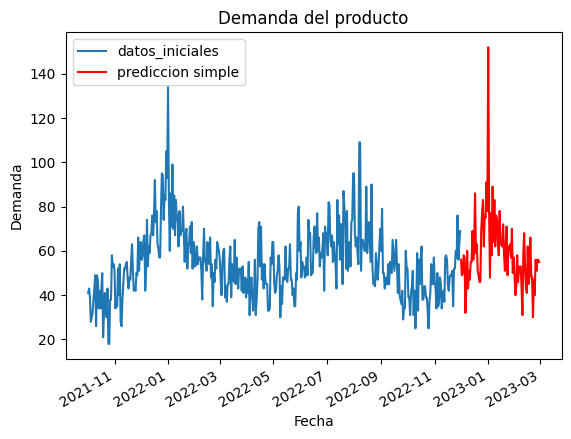

In [100]:
aux_df = complete_demanda_prod_df[complete_demanda_prod_df['date']>'2021-10-01']
plt.plot(aux_df.date, aux_df.demanda)
plt.plot(prediction_df['date'], prediction_df['prediccion_demanda'], color='r')

# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Rotar los x-ticks para mayor legibilidad
plt.gcf().autofmt_xdate()

plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title("Demanda del producto")
plt.legend(['datos_iniciales', 'prediccion simple'])


plt.show()

In [ ]:
# Validacion con funcion

# 2. Con un modelo Autoregresivo

# 3. Con una Red Neuronal Recurrente o LSTM